In [5]:
import json
import os
import time
import warnings
import sys

import h5py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
import pysam
import pyfaidx
import tensorflow as tf

from baskerville import seqnn
from baskerville import gene as bgene
from baskerville import dna

# Add the examples directory to the Python path
examples_path = os.path.abspath('examples')
sys.path.append(examples_path)
from borzoi_helpers import *

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [6]:
%%bash

#Download model weights
for rep in f0 f1 f2 f3; do
  mkdir -p "saved_models/$rep/"
  local_model="saved_models/$rep/model0_best.h5"
  if [ -f "$local_model" ]; then
    echo "$rep model already exists."
  else
    wget --progress=bar:force "https://storage.googleapis.com/seqnn-share/borzoi/$rep/model0_best.h5" -O "$local_model"
  fi
done

#Download and uncompress annotation files
if [ -f gencode41_basic_nort.gtf ]; then
  echo "Annotation already exists."
else
  wget -O - https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_nort.gtf.gz | gunzip -c > gencode41_basic_nort.gtf
fi
if [ -f gencode41_basic_protein_splice.csv.gz ]; then
  echo "Splice sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/gencode41_basic_protein_splice.csv.gz
fi
if [ -f polyadb_human_v3.csv.gz ]; then
  echo "PolyA sites already exist."
else
  wget https://storage.googleapis.com/seqnn-share/helper/polyadb_human_v3.csv.gz
fi

#Download and index hg38 genome
if [ -f hg38.fa ]; then
  echo "Human genome FASTA already exists."
else
  wget -O - http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz | gunzip -c > hg38.fa
fi

--2024-07-16 15:46:38--  https://storage.googleapis.com/seqnn-share/borzoi/f0/model0_best.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.42.219, 172.217.26.251, 142.251.222.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.42.219|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744112468 (710M) [application/octet-stream]
Saving to: ‘saved_models/f0/model0_best.h5’

saved_models/f0/mod 100%[===================>] 709.64M  32.2MB/s    in 23s     

2024-07-16 15:47:02 (30.4 MB/s) - ‘saved_models/f0/model0_best.h5’ saved [744112468/744112468]

--2024-07-16 15:47:02--  https://storage.googleapis.com/seqnn-share/borzoi/f1/model0_best.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.198.27, 172.217.175.123, 142.250.207.59, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.198.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 744112468 (710M) [a

In [7]:
pyfaidx.Faidx('hg38.fa')

Faidx("hg38.fa")

In [10]:
#Model configuration

params_file = 'examples/params_pred.json'
targets_file = 'examples/targets_gtex.txt' #Subset of targets_human.txt

seq_len = 524288
n_reps = 1       #To use only one model replicate, set to 'n_reps = 1'. To use all four replicates, set 'n_reps = 4'.
rc = True         #Average across reverse-complement prediction

#Read model parameters

with open(params_file) as params_open :
    
    params = json.load(params_open)
    
    params_model = params['model']
    params_train = params['train']

#Read targets

targets_df = pd.read_csv(targets_file, index_col=0, sep='\t')
target_index = targets_df.index

#Create local index of strand_pair (relative to sliced targets)
if rc :
    strand_pair = targets_df.strand_pair
    
    target_slice_dict = {ix : i for i, ix in enumerate(target_index.values.tolist())}
    slice_pair = np.array([
        target_slice_dict[ix] if ix in target_slice_dict else ix for ix in strand_pair.values.tolist()
    ], dtype='int32')

#Initialize model ensemble

models = []
for rep_ix in range(n_reps) :
    
    model_file = "saved_models/f" + str(rep_ix) + "/model0_best.h5"

    seqnn_model = seqnn.SeqNN(params_model)
    seqnn_model.restore(model_file, 0)
    seqnn_model.build_slice(target_index)
    if rc :
        seqnn_model.strand_pair.append(slice_pair)
    seqnn_model.build_ensemble(rc, [0])
    
    models.append(seqnn_model)


In [12]:
#Initialize fasta sequence extractor

fasta_open = pysam.Fastafile('hg38.fa')

#Load splice site annotation

splice_df = pd.read_csv('gencode41_basic_protein_splice.csv.gz', sep='\t', compression='gzip')

print("len(splice_df) = " + str(len(splice_df)))


len(splice_df) = 404837


In [13]:
#Load GTF (optional; needed to compute exon coverage attributions for example gene)

transcriptome = bgene.Transcriptome('gencode41_basic_nort.gtf')

search_gene = 'ENSG00000187164'
center_pos = 116952944
chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

#Get exon bin range
gene_keys = [gene_key for gene_key in transcriptome.genes.keys() if search_gene in gene_key]

gene = transcriptome.genes[gene_keys[0]]

#Determine output sequence start
seq_out_start = start + seqnn_model.model_strides[0]*seqnn_model.target_crops[0]
seq_out_len = seqnn_model.model_strides[0]*seqnn_model.target_lengths[0]

#Determine output positions of gene exons
gene_slice = gene.output_slice(seq_out_start, seq_out_len, seqnn_model.model_strides[0], False)


In [14]:
#Print index of GTEx blood and muscle tracks in targets file

targets_df['local_index'] = np.arange(len(targets_df))

print("blood tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:blood']['local_index'].tolist()))
print("muscle tracks = " + str(targets_df.loc[targets_df['description'] == 'RNA:muscle']['local_index'].tolist()))


blood tracks = [9, 10, 11]
muscle tracks = [47, 48, 49]


2023-09-26 11:12:04.278470: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-09-26 11:12:20.024423: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


-- Counts --
 - sum_wt = 134628.16
 - sum_mut = 136860.81
 - max_y_wt = 1051.197
 - max_y_mut = 1060.9895
 -- (max_y = 1060.9895)


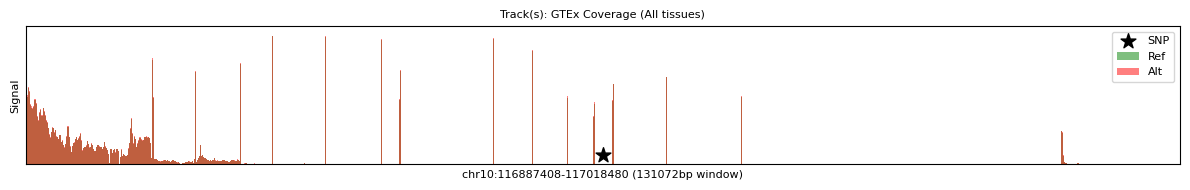

 - sum_wt = 75068.61
 - sum_mut = 90392.24
 - max_y_wt = 696.2884
 - max_y_mut = 837.6076
 -- (max_y = 837.6076)


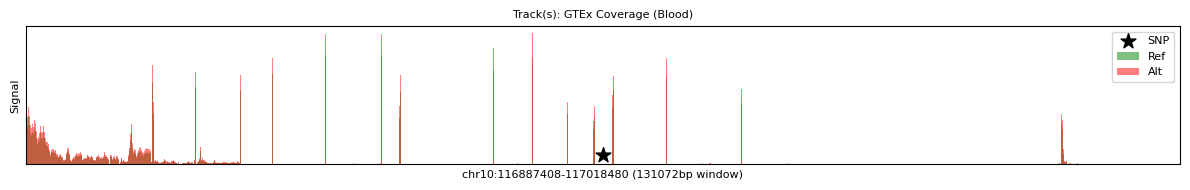

 - sum_wt = 44652.867
 - sum_mut = 45602.734
 - max_y_wt = 425.3462
 - max_y_mut = 430.3084
 -- (max_y = 430.3084)


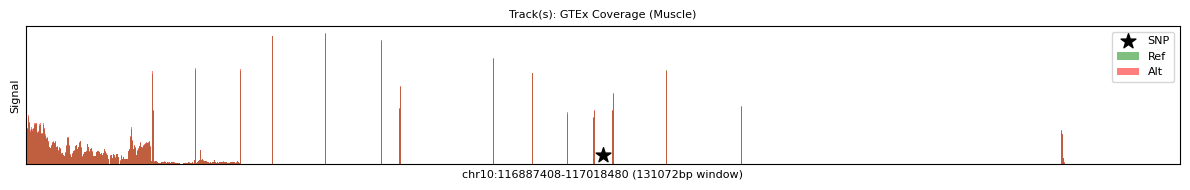

CPU times: user 56.5 s, sys: 1.8 s, total: 58.3 s
Wall time: 1min 28s


In [8]:
%%time
#Predict for chr10_116952944_T_C
# (~6 minutes on CPU w 1 replicate; ~2 minutes on GPU)

save_figs = False
save_suffix = '_chr10_116952944_T_C'

sequence_one_hot_wt = process_sequence(fasta_open, chrom, start, end)

#Induce mutation(s)
sequence_one_hot_mut = np.copy(sequence_one_hot_wt)

for pos, alt in zip(poses, alts) :
    alt_ix = -1
    if alt == 'A' :
        alt_ix = 0
    elif alt == 'C' :
        alt_ix = 1
    elif alt == 'G' :
        alt_ix = 2
    elif alt == 'T' :
        alt_ix = 3

    sequence_one_hot_mut[pos-start-1] = 0.
    sequence_one_hot_mut[pos-start-1, alt_ix] = 1.

#Make predictions
y_wt = predict_tracks(models, sequence_one_hot_wt)
y_mut = predict_tracks(models, sequence_one_hot_mut)

#Visualize quantized tracks over SNP

plot_window = 131072
bin_size = 32
pad = 16

rescale_tracks = True
normalize_counts = False

anno_df = None #splice_df

#Tracks
track_indices = [
    np.arange(0, 89).tolist(),
    [9, 10, 11],
    [47, 48, 49],
]

track_names = [
    'GTEx Coverage (All tissues)',
    'GTEx Coverage (Blood)',
    'GTEx Coverage (Muscle)',
]

track_scales = [0.01]*3
track_transforms = [3./4.]*3
soft_clips = [384.]*3

print("-- Counts --")
plot_coverage_track_pair_bins(
    y_wt,
    y_mut,
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=1 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)


In [9]:
%%time
#Get contribution scores (gradient) for blood GTEX tracks
# (~20 minutes on CPU; otherwise runnable only on 40GB GPU cards, e.g. A100)

_, _, [pred_grad_wt, pred_grad_mut] = get_prediction_gradient_w_rc(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=target_index[[9, 10, 11]].tolist(),
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=False,
    use_ratio=False,
    use_logodds=False,
    subtract_avg=True,
    fold_index=np.arange(n_reps).tolist(),
)


1/1 [==============================] - 220s 220s/step
CPU times: user 18min 50s, sys: 2min 46s, total: 21min 36s
Wall time: 23min 2s


--- WT ---


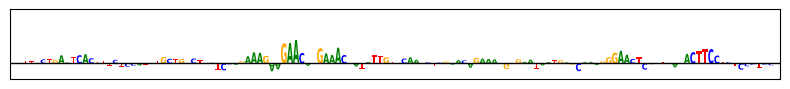

--- Mut ---


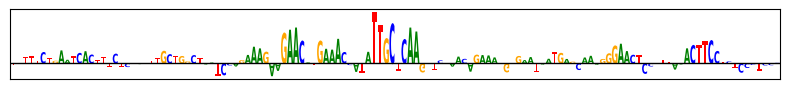

In [10]:
#Visualize gradient contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_grad_wt,
    pred_grad_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_grad_gtex_snp_4_reps_gtex_blood_cov_undo_clip'
)


In [11]:
%%time
#Get contribution scores (ISM) for blood GTEX tracks
# (not feasible to run on CPU; ~33 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
example_ix = 1
CPU times: user 16min 57s, sys: 1min 30s, total: 18min 28s
Wall time: 33min 52s


--- WT ---


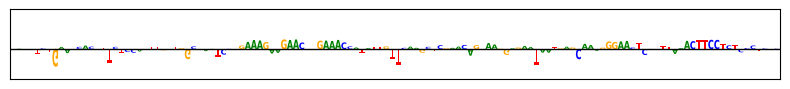

--- Mut ---


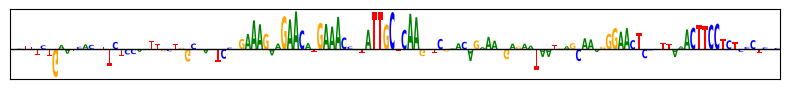

In [12]:
#Visualize ISM contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_gtex_snp_4_reps_gtex_blood_cov_undo_clip'
)


In [13]:
%%time
#Get contribution scores (ISM shuffle) for blood GTEX tracks
# (not feasible to run on CPU; ~135 minutes on GPU)

[pred_ism_wt, pred_ism_mut] = get_ism_shuffle(
    models,
    [sequence_one_hot_wt, sequence_one_hot_mut],
    ism_start=(poses[0] - start) - 64,
    ism_end=(poses[0] - start) + 64,
    prox_bin_start=0,
    prox_bin_end=1,
    dist_bin_start=0,
    dist_bin_end=1,
    track_index=[9, 10, 11],
    track_scale=0.01,
    track_transform=3./4.,
    clip_soft=384.,
    window_size=5,
    n_samples=12,
    dist_bin_index=gene_slice.tolist(),
    use_mean=True,
    use_ratio=False,
    use_logodds=False,
)


example_ix = 0
example_ix = 1
CPU times: user 1h 6min 55s, sys: 6min 8s, total: 1h 13min 3s
Wall time: 2h 15min 9s


--- WT ---


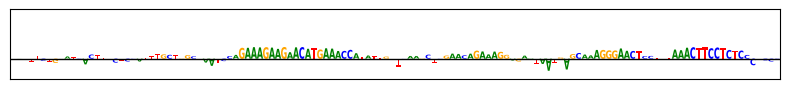

--- Mut ---


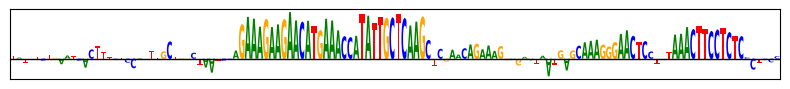

In [14]:
#Visualize ISM Shuffle contribution scores (128 bp window centered on variant)

visualize_input_gradient_pair(
    pred_ism_wt,
    pred_ism_mut,
    plot_start=(poses[0] - start) - 64,
    plot_end=(poses[0] - start) + 64,
    save_figs=False,
    fig_name=chrom + '_' + str(poses[0]) + '_prediction_ism_shuffle_gtex_snp_4_reps_gtex_blood_cov_undo_clip'
)


In [15]:
#Load samples with reference- and alternate alleles respectively

#These files are protected by dbGaP - email to request access

cov_files_wt = pd.read_csv("gtex_ref_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()
cov_files_mut = pd.read_csv("gtex_alt_chr10_116952944_T_C.txt", sep='\t', names=['file'])['file'].values.tolist()


gtex_targets_wt.shape = (16352, 32)
gtex_targets_mut.shape = (16352, 32)
-- Counts --
 - sum_wt = 27668.607
 - sum_mut = 37653.69
 - max_y_wt = 241.0508
 - max_y_mut = 370.9016
 -- (max_y = 370.9016)


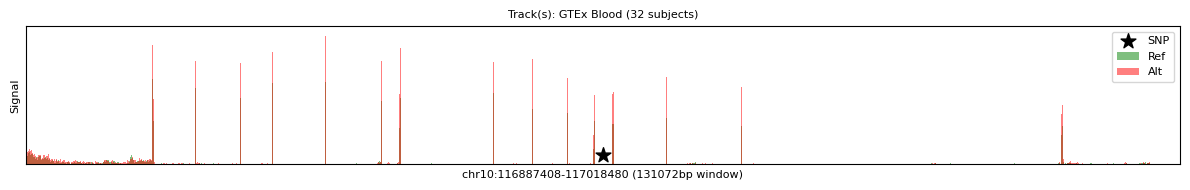

In [16]:
#Visualize measured coverage tracks for chr10_116952944_T_C

save_figs = False
save_suffix = '_chr10_116952944_T_C_meas_32_subjects'

center_pos = 116952944

chrom = 'chr10'
poses = [116952944]
alts = ['C']

start = center_pos - seq_len // 2
end = center_pos + seq_len // 2

blacklist_bed = "/home/drk/common/data/genomes/hg38/blacklist/blacklist_hg38_all.bed"

read_coverage_func_wt, close_coverage_func_wt = get_coverage_reader(cov_files_wt, 16384, 16, blacklist_bed)
read_coverage_func_mut, close_coverage_func_mut = get_coverage_reader(cov_files_mut, 16384, 16, blacklist_bed)

gtex_targets_wt = read_coverage_func_wt(chrom, start, end, clip_soft=384., clip=768., scale=0.01)
gtex_targets_mut = read_coverage_func_mut(chrom, start, end, clip_soft=384., clip=768., scale=0.01)

close_coverage_func_wt()
close_coverage_func_mut()

print("gtex_targets_wt.shape = " + str(gtex_targets_wt.shape))
print("gtex_targets_mut.shape = " + str(gtex_targets_mut.shape))

plot_window = 131072
bin_size = 32
pad = 16

anno_df = None #splice_df

rescale_tracks = True
normalize_counts = True

#Tracks
track_indices = [
    np.arange(32).tolist(),
]

track_names = [
    'GTEx Blood (32 subjects)',
]

track_scales = [
    0.01,
]

track_transforms = [
    3./4.,
]

soft_clips = [
    384.,
]

print("-- Counts --")
plot_coverage_track_pair_bins(
    gtex_targets_wt[None, None, ...],
    gtex_targets_mut[None, None, ...],
    chrom,
    start,
    center_pos,
    poses,
    track_indices,
    track_names,
    track_scales,
    track_transforms,
    soft_clips,
    plot_window=plot_window,
    normalize_window=4 * plot_window,
    bin_size=bin_size,
    pad=pad,
    rescale_tracks=rescale_tracks,
    normalize_counts=normalize_counts,
    save_figs=save_figs,
    save_suffix=save_suffix,
    gene_slice=gene_slice,
    anno_df=anno_df,
)
